# Day4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 손실함수

,params,score
0,"[-1.0, 1.0]",36.254900
1,"[1.0, 0.0]",1.018294
2,"[1.0032193455976284, -0.0635741662734181]",1.014164
3,"[-0.06357416627341769, 1.0032193455976282]",11.825624


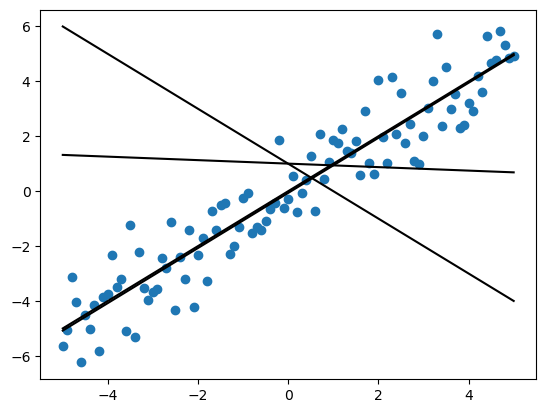

In [34]:
from sklearn.linear_model import LinearRegression


xs = np.linspace(-5, 5, 101)
noise = np.random.default_rng(seed=4).normal(0, 1, size=xs.shape)
ys = xs + noise

#선형모형
f = lambda x, w, b: w * x + b

params = []
params.append(np.array([-1.0, 1.])) # 초기값
params.append(np.array([1.0, 0.0])) # DGP

data = xs.reshape(-1, 1); target = ys
linreg = LinearRegression()
linreg.fit(data, target)
# 알고리즘 결과
params.append(np.array([linreg.coef_[0], linreg.intercept_]))
w, b = linreg.coef_, linreg.intercept_
assert np.allclose(f(xs, linreg.coef_[0], linreg.intercept_), linreg.predict(data))

# 정규 방정식
X = np.vstack([np.ones(xs.size), xs]).T # 디자인 행렬
최적해 = np.linalg.inv(X.T @ X) @ X.T @ ys # 정규 방정식의 해 (X^T X)^-1 X^T y
params.append(최적해)
assert np.allclose(최적해, np.append(b, w))


평균제곱오차 = lambda y_true, y_pred : np.mean((y_true - y_pred) ** 2)
scores = []

for w, b in params:
    y_pred = f(xs, w, b)
    score = 평균제곱오차(ys, y_pred)
    scores.append(score)

display(pd.DataFrame(zip(params, scores), columns=['params', 'score']))

plt.scatter(xs, ys)
for w, b in params:
    plt.plot(xs, f(xs, w, b), 'k')
plt.show()


In [35]:
class 다중퍼셉트론:
    def __init__(self, 입력수, 출력수, 활성화=None, seed=None):
        random = np.random.default_rng(seed)
        self.W = np.random.normal(size=(입력수, 출력수))
        self.b = np.zeros(출력수, dtype=np.float32)
        self.활성화 = 활성화
    def __call__(self, x):
        z = x @ self.W + self.b
        if self.활성화 is not None:
            z = self.활성화(z)
        return z
     

class 신경망:
    def __init__(self):
        self.layers = []
    def add(self, layer):
        self.layers.append(layer)
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # 
        return x        

## MNIST

In [36]:
from torchvision.datasets import MNIST

mnist = {}
mnist['train'] = MNIST(root='~/data', train=True, download=True) # ~/의 의미 : 홈 디렉토리 (바인드 되어 있는 이 컴퓨터 디렉토리가 아님.)
mnist['test'] = MNIST(root='~/data', train=False, download=True)

print(mnist['train'].data.shape, mnist['test'].data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [50]:
def 전처리(images):
    if not isinstance(images, np.ndarray):
        images = images.numpy()
    X = images.reshape(-1, 28*28).astype(np.float32) / 255.0    
    return X

train_data = 전처리(mnist['train'].data)
train_target = np.array(mnist['train'].targets)
test_data = 전처리(mnist['test'].data)
test_target = np.array(mnist['test'].targets)

print(train_data.shape, test_data.shape)
assert np.isclose(train_data.max(), 1.0) and np.isclose(test_data.max(), 1.0)



(60000, 784) (10000, 784)


In [73]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def softmax(x):
    # overflow 문제 해결
    x_max = np.max(x, axis=1, keepdims=True)
    x_exp = np.exp(x - x_max)
    return x_exp / np.sum(x_exp, axis=1, keepdims=True)

model = 신경망()
model.add(다중퍼셉트론(28*28, 50, 활성화=sigmoid))
model.add(다중퍼셉트론(50, 100, 활성화=sigmoid))
model.add(다중퍼셉트론(100, 10, 활성화=softmax))

outputs = model(test_data)
print(outputs.shape)
y_pred = np.argmax(outputs, axis=1)
print(f'정확도: {np.mean(y_pred == test_target):.2%}')

display(pd.DataFrame(outputs).assign(pred=y_pred, target=test_target)[:5].round(3))


(10000, 10)
정확도: 10.62%


,0,1,2,3,4,5,6,7,8,9,pred,target
0,0.003,0.0,0.0,0.000,0.387,0.014,0.583,0.0,0.014,0.0,6,7
1,0.000,0.0,0.0,0.000,0.021,0.878,0.002,0.0,0.099,0.0,5,2
2,0.011,0.0,0.0,0.003,0.011,0.118,0.006,0.0,0.851,0.0,8,1
3,0.000,0.0,0.0,0.001,0.979,0.010,0.009,0.0,0.001,0.0,4,0
4,0.000,0.0,0.0,0.006,0.870,0.030,0.079,0.0,0.014,0.0,4,4


## 원-핫 인코딩

다주 분류 출력은 확률 분포 형식이기 때문에 오차의 측정을 위해 정답 라벨을 확률 분포 형식으르 변환하여 비교해야 한다. 

변환하는 방식은 One Hot Encoding으로 달성할 수 있다. 

In [86]:
유형수 = len(np.unique(train_target))
원핫행렬 = np.eye(유형수)
pd.DataFrame(원핫행렬.astype(int))

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,1


In [87]:
pd.DataFrame(원핫행렬[test_target]).assign(label = test_target).head()

,0,1,2,3,4,5,6,7,8,9,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4


분류 출력은 정답과 확률 분포의 차이를 오차로서 측정

In [88]:
outputs = model(test_data)

pd.DataFrame({
    'pred': outputs[0].round(3),    
    'one-hot': 원핫행렬[test_target][0],
    'error': np.abs(outputs[0] - 원핫행렬[test_target][0])
}).T.round(3)

,0,1,2,3,4,5,6,7,8,9
pred,0.003,0.0,0.0,0.0,0.387,0.014,0.583,0.0,0.014,0.0
one-hot,0.000,0.0,0.0,0.0,0.000,0.000,0.000,1.0,0.000,0.0
error,0.003,0.0,0.0,0.0,0.387,0.014,0.583,1.0,0.014,0.0


$$
L = \frac{1}{2} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\text{여기서:} \\
y_i \text{ : 실제값(관측값)} \\
\hat{y}_i \text{ : 예측값} \\
n \text{ : 데이터 포인트 개수} \\
(y_i - \hat{y}_i) \text{ : 오차(residual)}
$$

In [89]:
error = outputs - 원핫행렬[test_target]
오차제곱합 = np.sum(error ** 2, axis=1)

pd.DataFrame(outputs).assign(sse=오차제곱합, true= test_target).head().round(3)

,0,1,2,3,4,5,6,7,8,9,sse,true
0,0.003,0.0,0.0,0.000,0.387,0.014,0.583,0.0,0.014,0.0,1.490,7
1,0.000,0.0,0.0,0.000,0.021,0.878,0.002,0.0,0.099,0.0,1.781,2
2,0.011,0.0,0.0,0.003,0.011,0.118,0.006,0.0,0.851,0.0,1.738,1
3,0.000,0.0,0.0,0.001,0.979,0.010,0.009,0.0,0.001,0.0,1.959,0
4,0.000,0.0,0.0,0.006,0.870,0.030,0.079,0.0,0.014,0.0,0.024,4


In [92]:
def 오차제곱합(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2, axis=1)

def 교차엔트로피(y_true, y_pred):
    delta = 1e-7
    return -np.sum(y_true * np.log(y_pred + delta), axis=1)

y_pred = np.argmax(outputs, axis=1)
pd.DataFrame(outputs).assign(
    sse=오차제곱합(원핫행렬[test_target], outputs),
    cee=교차엔트로피(원핫행렬[test_target], outputs),
    pred=y_pred,
    true=test_target
).head().round(3)


,0,1,2,3,4,5,6,7,8,9,sse,cee,pred,true
0,0.003,0.0,0.0,0.000,0.387,0.014,0.583,0.0,0.014,0.0,1.490,12.557,6,7
1,0.000,0.0,0.0,0.000,0.021,0.878,0.002,0.0,0.099,0.0,1.781,14.266,5,2
2,0.011,0.0,0.0,0.003,0.011,0.118,0.006,0.0,0.851,0.0,1.738,14.572,8,1
3,0.000,0.0,0.0,0.001,0.979,0.010,0.009,0.0,0.001,0.0,1.959,9.318,4,0
4,0.000,0.0,0.0,0.006,0.870,0.030,0.079,0.0,0.014,0.0,0.024,0.139,4,4


0.0 2.302585092994046


/tmp/ipykernel_44669/3216042067.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x), 'k')


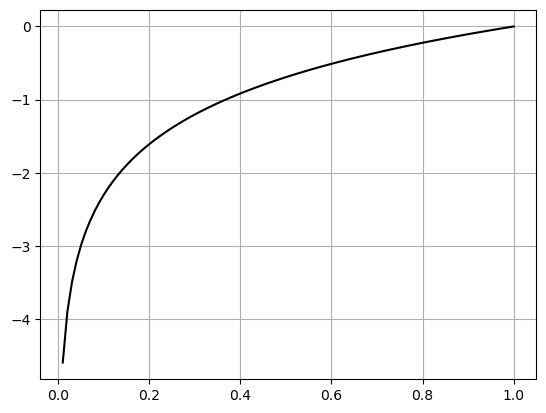

In [110]:
# loge 를 비분한 것의 그래프
x = np.linspace(0, 1, 100)

plt.plot(x, np.log(x), 'k')
plt.grid()

print(np.log(1), np.log(10))


